# Simple fMRI preprocessing pipeline
This notebook describes a simple preprocessing pipeline for fMRI data, using the [nipype](http://nipy.org/nipype/) environment/package (Gorgolewski K., et al., 2011, Front. Neurinform. 5:13), in which a combination of FSL-software and custom Python scripts are used. 

Lukas Snoek, University of Amsterdam (lukassnoek@gmail.com)

## Packages and settings
Below, necessary packages are imported and some pipeline-specific variables are defined.

In [2]:
# Importing necessary packages
import os
import os.path as op
import glob
import nipype
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nibabel as nib
from IPython.display import Image
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from IPython.display import Image

# Assuming the notebook is run from within its own directory,
# we'll import the custom functions here.
from nodes import filtering

%matplotlib inline

ValueError: Attempted relative import in non-package

In [4]:
from nipype.interfaces.fsl import Info
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')
Info.standard_image = 'MNI152_T1_2mm_brain.nii.gz'

## Setting up the project structure
Ideally, Nipype seems to work from a structure in which files exists in a hierachy as follows: <br> project-root >> subject-specific directory >> run-specific directory >> run-specific files (nifti, log, phy, etc.).

The class DataOrganizer from the create_dir_structure module does this.
To intialize the DatOrganizer object, it needs to know the 'names' (keywords) of the functional and structural run(s) and the subject-name prefix (here: 'sub'). Already converted indicates that the PAR/REC shouldn't be converted to nifti again (as it's done already).

In [2]:
project_dir = os.path.join(os.path.expanduser('~'), 'test_nipype')
subject_stem = 'sub'
run_names = {'func': ['hww', 'zinnen1', 'zinnen2'],
             'struc': 'T1'}

data_organizer = DataOrganizer(run_names=run_names, project_dir=project_dir, 
                               subject_stem=subject_stem, already_converted=True)

To run the pipeline described below, you can download some example data from my dataset, using the method 'fetch_test_data'.

In [3]:
data_organizer.fetch_test_data()

'Already downloaded!'

In [4]:
data_organizer.convert_parrec2nifti()
data_organizer.create_project_tree()

Done with conversion of par/rec to nifti.


By now, there should be a working directory (working_directory) with the project-tree and a backup-directory if you want to revert back to the original files. The structure, by now, should look like this:
![hello](https://github.com/lukassnoek/nipype_testing/raw/master/dirstructure.png)

## Preprocessing
Definition of nodes within pipeline + inputs (infosource / selectfiles) + outputs (datasink)

In [9]:
# Parameters
subject_list = [op.basename(f) for f in data_organizer.subject_dirs]
run_list = ['func_hww', 'func_zinnen1', 'func_zinnen2']

wd = data_organizer.working_dir
datasink_dir = 'datasink_preprocessing'        
nipype_output_dir = 'nipype_output'     

frac_T1 = 0.4
frac_epi = 0.2
robust_bet = True
fwhm = 5.0
mcflt_cost = 'mutualinfo'
TR = 2.0

## Simple workflow

In [10]:
# Infosource simply distributes iterables for parallel processing
infosource = pe.Node(IdentityInterface(fields=['subject_id']), name="infosource")
infosource.iterables = [('subject_id', subject_list)]
# you can also specify other iterables, such as models or runs 

template = {
    'func': '%s/{subject_id}/func_*/*.nii.gz' % wd,
    'struc': '%s/{subject_id}/T1/*.nii.gz' % wd,
    'log': '%s/{subject_id}/*/*.log' % wd}

selectfiles = pe.Node(SelectFiles(template, base_directory=wd), name="selectfiles")

In [11]:
reorient_T1 = pe.Node(interface=fsl.Reorient2Std(), name='reorient_T1')
bet_T1 = pe.Node(interface=fsl.BET(frac=frac_T1, robust=robust_bet), name='bet_T1')
fast = pe.Node(interface=fsl.FAST(), name='segment')

get_scaninfo = pe.MapNode(util.Function(input_names=['in_file'],
                                        output_names=['TR', 'shape', 'dyns', 'voxsize', 'affine'],
                                        function=load_scaninfo),
                          name='get_scaninfo',
                          iterfield='in_file')

reorient_epi = pe.MapNode(interface=fsl.Reorient2Std(), name='reorient_epi', iterfield='in_file')
bet_epi = pe.MapNode(interface=fsl.BET(frac=frac_epi, functional=True), name='bet_epi', iterfield='in_file')

findmiddlerun = pe.Node(util.Function(input_names=['in_files'],
                                           output_names=['middle_run', 'other_runs'],
                                           function=find_middle_run),
                            name='find_middle_run')

mean_bold = pe.Node(interface=fsl.maths.MeanImage(dimension='T'), name='mean_bold')

mcflirt_middle = pe.Node(interface=fsl.MCFLIRT(cost=mcflt_cost, interpolation='sinc', stages=3, save_plots=True),
                            name='mcflirt_middle')

mcflirt_rest = pe.MapNode(interface=fsl.MCFLIRT(cost=mcflt_cost, interpolation='sinc', stages=3, save_plots=True),
                       name='mcflirt_rest', iterfield='in_file')

mcflirt = pe.Node(util.Function(input_names=['in_file'],
                                           output_names=['out_files', 'mean_bold', 'plot_files'],
                                           function=mcflirt_across_runs),
                            name='mcflirt')

plot_motion = pe.MapNode(interface=fsl.PlotMotionParams(in_source='fsl'),
                        name='plot_motion',
                        iterfield=['in_file'])

plot_motion.iterables = ('plot_type', ['rotations', 'translations'])

slicetimer = pe.MapNode(interface=fsl.SliceTimer(interleaved=False), 
                        name='slicetimer', 
                        iterfield=['in_file', 'time_repetition'])

smooth = pe.MapNode(interface=fsl.IsotropicSmooth(fwhm=fwhm), 
                    name='smooth', iterfield=['in_file'])

sgfilter = pe.MapNode(util.Function(input_names=['in_file'],
                                    output_names=['out_file'],
                                    function=apply_sg_filter),
                      iterfield=['in_file'],
                      name='sgfilter')

datasink = pe.Node(DataSink(base_directory=data_organizer.project_dir, container=datasink_dir), name="datasink")
substitutions = [('_subject_id_', '')]
datasink.inputs.substitutions = substitutions

mcflirt_merger_infiles = pe.Node(interface=util.Merge(2), name='mcflirt_merger_infiles')
mcflirt_merger_motionplots = pe.Node(interface=util.Merge(2), name='mcflirt_merger_motionplots')

INFO:workflow:Creating detailed dot file: /home/lukas/test_nipype/test_data/preproc/graph_detailed.dot
INFO:workflow:Creating dot file: /home/lukas/test_nipype/test_data/preproc/graph.dot


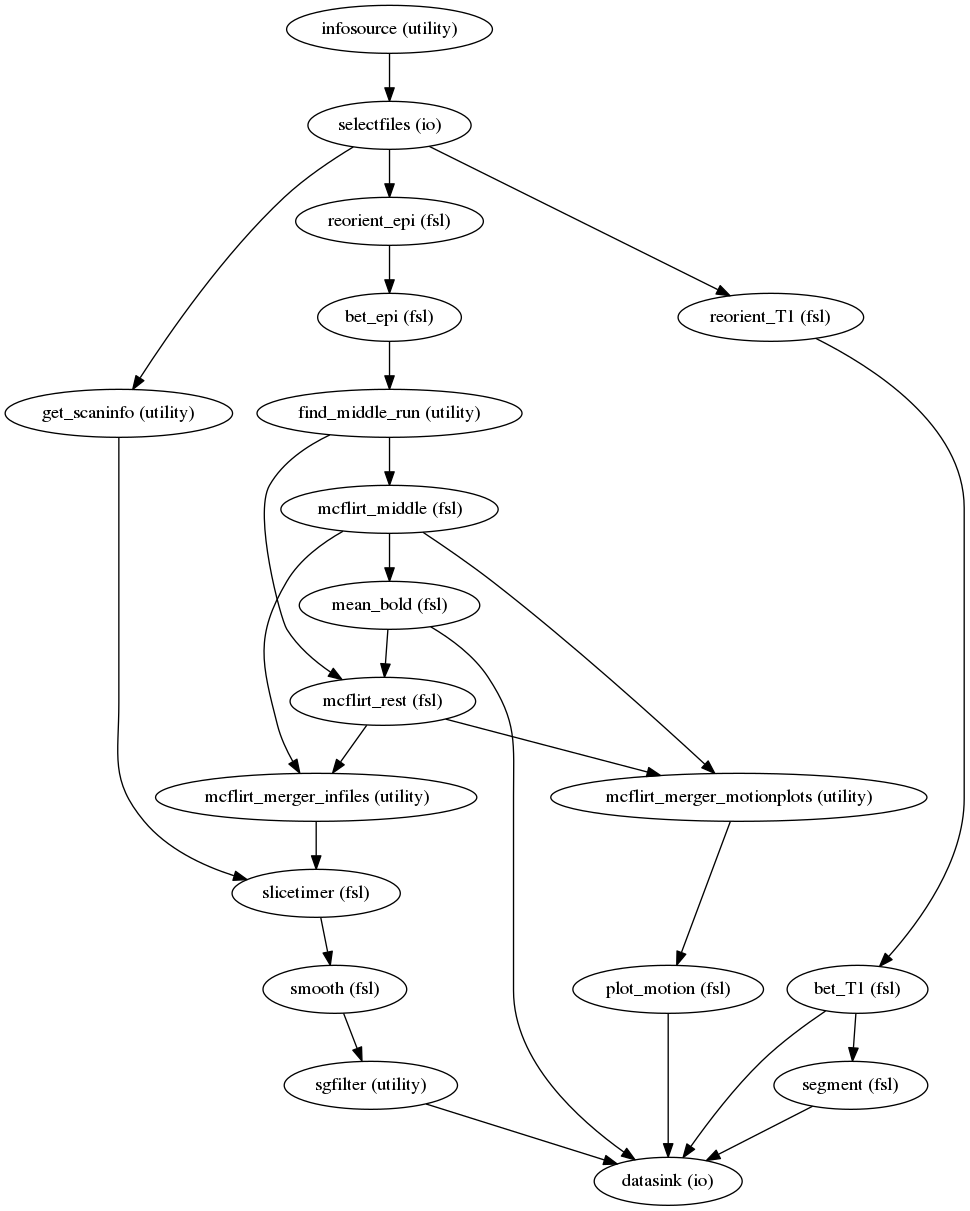

In [13]:
preproc = pe.Workflow(name='preproc')
preproc.base_dir = data_organizer.project_dir
preproc.connect(infosource, 'subject_id', selectfiles, 'subject_id')

preproc.connect(selectfiles, 'struc', reorient_T1, 'in_file')
preproc.connect(reorient_T1, 'out_file', bet_T1, 'in_file')
preproc.connect(bet_T1, 'out_file', datasink, 'bett1')
preproc.connect(bet_T1, 'out_file', fast, 'in_files')
preproc.connect(fast, 'tissue_class_files', datasink, 'fast')

preproc.connect(selectfiles, 'func', reorient_epi, 'in_file')
preproc.connect(reorient_epi, 'out_file', bet_epi, 'in_file')

preproc.connect(bet_epi, 'out_file', findmiddlerun, 'in_files')
preproc.connect(findmiddlerun, 'middle_run', mcflirt_middle, 'in_file')
preproc.connect(mcflirt_middle, 'out_file', mean_bold, 'in_file')
preproc.connect(mean_bold, 'out_file', mcflirt_rest, 'ref_file')
preproc.connect(findmiddlerun, 'other_runs', mcflirt_rest, 'in_file')
preproc.connect(mcflirt_middle, 'out_file', mcflirt_merger_infiles, 'in1')
preproc.connect(mcflirt_rest, 'out_file', mcflirt_merger_infiles, 'in2')
preproc.connect(mcflirt_merger_infiles, 'out', slicetimer, 'in_file')

preproc.connect(mcflirt_middle, 'par_file', mcflirt_merger_motionplots, 'in1')
preproc.connect(mcflirt_rest, 'par_file', mcflirt_merger_motionplots, 'in2')
preproc.connect(mcflirt_merger_motionplots, 'out', plot_motion, 'in_file')
preproc.connect(plot_motion, 'out_file', datasink, 'mcplots')
preproc.connect(mean_bold, 'out_file', datasink, 'meanbold')

preproc.connect(slicetimer, 'slice_time_corrected_file', smooth, 'in_file')
preproc.connect(smooth, 'out_file', sgfilter, 'in_file')
preproc.connect(selectfiles, 'func', get_scaninfo, 'in_file')
preproc.connect(get_scaninfo, 'TR', slicetimer, 'time_repetition')

preproc.connect(sgfilter, 'out_file', datasink, 'fullypreproc')

preproc.write_graph(simple_form=True, graph2use='flat')
Image(filename=os.path.join(data_organizer.project_dir, preproc.name, 'graph.dot.png'))

In [6]:
# Run workflow!
preproc.config = {'execution' : {'stop_on_first_crash' : True,
                                 'keep_inputs': True,
                                 'remove_unnecessary_outputs': False}}
graph = preproc.run('MultiProc', plugin_args={'n_procs': 10})

"\npreproc.config = {'execution' : {'stop_on_first_crash' : True,\n                                 'keep_inputs': True,\n                                 'remove_unnecessary_outputs': False}}\ngraph = preproc.run('MultiProc', plugin_args={'n_procs': 10})\n"

# First-level GLM (testing)
Some code to mess around with first-level modelling (using both Nipy and FSL).

In [ ]:
infosource_level1 = pe.Node(IdentityInterface(fields=['subject_id']), name="infosource_level1")
infosource_level1.iterables = [('subject_id', subject_list)]
# you can also specify other iterables, such as models or runs 

preproc_outdir = op.join(data_organizer.project_dir, datasink_dir)

template_level1 = {
    'zinnen_func': '%s/fullypreproc/{subject_id}/*/*innen*' % preproc_outdir,
    'hww_func': '%s/fullypreproc/{subject_id}/*/*HWW*'% preproc_outdir,
    'zinnen_log': '%s/{subject_id}/*zinnen?/*.log' % wd,
    'hww_log': '%s/{subject_id}/*hww/*.log' % wd}

selectfiles_level1 = pe.Node(SelectFiles(template_level1), name="selectfiles")
merger_models = pe.Node(interface=util.Merge(2), name='merger_models')
merger_funcs = pe.Node(interface=util.Merge(2), name='merger_funcs')

In [ ]:
# model specification
zinnen_names = ['Action', 'Interoception', 'Situation']
zinnen_codes = [[100, 199], [200, 299], [300, 399]]
zinnen_design = ['univar', 'univar', 'univar']

hww_names = ['Action', 'Interoception', 'Situation', 'Cue']
hww_codes = [[100, 199], [200, 299], [300, 399], ['Cue']]
hww_design = ['univar', 'univar', 'univar', 'univar']

In [ ]:
logfile_parser_zinnen = pe.MapNode(util.Function(
        input_names=['in_file', 'con_names', 'con_codes', 'con_design', 'pulsecode'],
        output_names='subject_info',function=parse_presentation_logfile),
                                   name='zinnen_parser', iterfield='in_file')
logfile_parser_zinnen.inputs.con_names = zinnen_names
logfile_parser_zinnen.inputs.con_codes = zinnen_codes
logfile_parser_zinnen.inputs.con_design = zinnen_design

logfile_parser_hww = pe.Node(util.Function(
        input_names=['in_file', 'con_names', 'con_codes', 'con_design', 'pulsecode'],
        output_names='subject_info', function=parse_presentation_logfile),
                             name='hww_parser')

logfile_parser_hww.inputs.con_names = hww_names
logfile_parser_hww.inputs.con_codes = hww_codes
logfile_parser_hww.inputs.con_design = hww_design

In [ ]:
modelspec = pe.MapNode(modelgen.SpecifyModel(), name='modelspec', iterfield=['functional_runs', 'subject_info'])
modelspec.inputs.input_units = 'secs'
modelspec.inputs.time_repetition = 2. # link to load_scaninfo param?
modelspec.inputs.high_pass_filter_cutoff = 128.

fitter = pe.MapNode(model.FitGLM(method='kalman', TR=2.0, drift_model='Blank',
                                plot_design_matrix=True, save_residuals=True),
                    name='fitter', iterfield='session_info')

datasink_level1 = pe.Node(DataSink(base_directory=data_organizer.project_dir, container='datasink_level1'),
                    name="datasink")
substitutions = [('_subject_id_', '')]
datasink_level1.inputs.substitutions = substitutions

In [ ]:
level1 = pe.Workflow(name='level1')
level1.base_dir = data_organizer.project_dir
level1.connect(infosource_level1, 'subject_id', selectfiles_level1, 'subject_id')
level1.connect(selectfiles_level1, 'zinnen_log', logfile_parser_zinnen, 'in_file')
level1.connect(selectfiles_level1, 'hww_log', logfile_parser_hww, 'in_file')
level1.connect(logfile_parser_hww, 'subject_info', merger_models, 'in1')
level1.connect(logfile_parser_zinnen, 'subject_info', merger_models, 'in2')
level1.connect(selectfiles_level1, 'hww_func', merger_funcs, 'in1')
level1.connect(selectfiles_level1, 'zinnen_func', merger_funcs, 'in2')
level1.connect(merger_funcs, 'out', modelspec, 'functional_runs')
level1.connect(merger_models, 'out', modelspec, 'subject_info')
level1.connect(modelspec, 'session_info', fitter, 'session_info')
level1.connect(fitter, 'beta', datasink_level1, 'level1_outputs.@beta')
level1.connect(fitter, 'residuals', datasink_level1, 'level1_outputs.@residuals')

level1.write_graph(simple_form=True, graph2use='flat')
Image(filename=os.path.join(data_organizer.project_dir, level1.name, 'graph.dot.png'))

level1.config = {'execution' : {'keep_inputs': True,
                                'remove_unnecessary_outputs': False}}
graph = level1.run('MultiProc', plugin_args={'n_procs': 6})

In [ ]:
datasink_fsl = pe.Node(DataSink(base_directory=data_organizer.project_dir, container='datasink_fsl'),
                    name="datasink")
substitutions = [('_subject_id_', '')]
datasink_fsl.inputs.substitutions = substitutions

fsl_design = pe.MapNode(fsl.model.Level1Design(
        interscan_interval=2.0, bases={'dgamma':{'derivs': False}}, model_serial_correlations=True),
                        name='fsl_design', iterfield='session_info')

fsl_model = pe.MapNode(fsl.model.FEATModel(), name='fsl_model', iterfield=['fsf_file', 'ev_files'])
fsl_glm = pe.MapNode(fsl.FILMGLS(), name='fsl_glm', iterfield=['design_file', 'in_file'])

level1_fsl = pe.Workflow(name='level1_fsl')
level1_fsl.base_dir = data_organizer.project_dir
level1_fsl.connect(infosource_level1, 'subject_id', selectfiles_level1, 'subject_id')
level1_fsl.connect(selectfiles_level1, 'zinnen_log', logfile_parser_zinnen, 'in_file')
level1_fsl.connect(selectfiles_level1, 'hww_log', logfile_parser_hww, 'in_file')
level1_fsl.connect(logfile_parser_hww, 'subject_info', merger_models, 'in1')
level1_fsl.connect(logfile_parser_zinnen, 'subject_info', merger_models, 'in2')
level1_fsl.connect(selectfiles_level1, 'hww_func', merger_funcs, 'in1')
level1_fsl.connect(selectfiles_level1, 'zinnen_func', merger_funcs, 'in2')
level1_fsl.connect(merger_funcs, 'out', modelspec, 'functional_runs')
level1_fsl.connect(merger_models, 'out', modelspec, 'subject_info')
level1_fsl.connect(modelspec, 'session_info', fsl_design, 'session_info')
level1_fsl.connect(fsl_design, 'fsf_files', fsl_model, 'fsf_file')
level1_fsl.connect(fsl_design, 'ev_files', fsl_model, 'ev_files')
level1_fsl.connect(fsl_model, 'design_file', fsl_glm, 'design_file')
level1_fsl.connect(merger_funcs, 'out', fsl_glm, 'in_file')

level1_fsl.write_graph(simple_form=True, graph2use='flat')
Image(filename=os.path.join(data_organizer.project_dir, level1_fsl.name, 'graph.dot.png'))

In [ ]:
level1_fsl.config = {'execution' : {'keep_inputs': True,
                                'remove_unnecessary_outputs': False}}
graph = level1_fsl.run('MultiProc', plugin_args={'n_procs': 5})